In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pathlib
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.models import ResNet18_Weights
import keras

# mean = np.array([0.5, 0.5, 0.5])
# std = np.array([0.25, 0.25, 0.25])

#training_set = ImageFolder("Task2_dataset//training")
# data_dir = 'Task2_dataset/training'
# image_datasets = {x: datasets.ImageFolder(os.path.join(
#     data_dir, x), data_transforms[x]) for x in ['training', 'testing']}
# dataloaders = {x: torch.utils.data.DataLoader(
#     image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['training', 'testing']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}
# class_names = image_datasets['training'].classes
# print(class_names)

transform = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
training_set = ImageFolder("Task2_dataset//training", transform=transform)
val_size = 120
train_size = len(training_set) - val_size
train_ds, val_ds = random_split(training_set, [train_size, val_size])
len(train_ds), len(val_ds)
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, num_workers=0)
root = pathlib.Path("Task2_dataset//training")
class_names = sorted([j.name.split('/')[-1] for j in root.iterdir()])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is set to", device)
print(class_names)
print(train_loader)


2023-11-10 19:01:48.949109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 19:01:48.949158: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 19:01:48.951655: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 19:01:49.212148: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 19:01:50.927240: W tensorflow/compiler/

Device is set to cpu
['Combat', 'DestroyedBuildings', 'Fire', 'Humanitarian Aid and rehabilitation', 'Military vehicles and weapons']


In [3]:
def plot_losses(loss_values, epoch, n_epochs):
    x0 = list(range(1, epoch+1))
    plt.figure(figsize=(5, 2))
    plt.plot(x0, loss_values)
    plt.title('Model loss')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


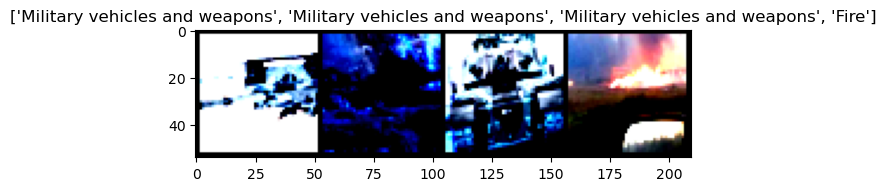

In [4]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:

# Load the VGG16 model
vgg16 = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)

# Define the input shape
input_shape = (224, 224, 3)

# Create the model
model = keras.Sequential([
    vgg16,
    keras.layers.Dense(1000, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10)

# Evaluate the model
model.evaluate(x_test, y_test)

# Save the model
model.save('vgg16.h5')

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Task2_dataset//training'
test_data_dir = 'Task2_dataset//testing'


# Load the VGG16 model with pre-trained weights
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Freeze all the layers of VGG16
for layer in vgg16.layers:
    layer.trainable = False

# Add a new classification layer
classification_layer = tf.keras.Sequential([
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# Add the new classification layer to the VGG16 model
vgg16.add(classification_layer)

# Compile the model
vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the training data
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.load_data()
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load your training data using the ImageDataGenerator object
x_train = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(50, 50),
    batch_size=32,
    class_mode='categorical')
x_test = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(50, 50),
    batch_size=32,
    class_mode='categorical')


# Resize the training and test images to 50 by 50 pixels
x_train = tf.image.resize(x_train, (50, 50))
x_test = tf.image.resize(x_test, (50, 50))

# Normalize the training and test images
x_train = x_train / 255.0
x_test = x_test / 255.0

# # Convert the training and test labels to one-hot encoded vectors
# y_train = tf.keras.utils.to_categorical(y_train, 5)
# y_test = tf.keras.utils.to_categorical(y_test, 5)

# Train the model
vgg16.fit(x_train, y_train, epochs=10)

# Evaluate the model on the test data
test_loss, test_accuracy = vgg16.evaluate(x_test, y_test)

# Print the test accuracy
print('Test accuracy:', test_accuracy)


AttributeError: 'Functional' object has no attribute 'add'

In [8]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
])

# Load your dataset (assuming it's organized as per torchvision.datasets.ImageFolder)
train_dataset = datasets.ImageFolder(root='/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task 2/Task 2C/root/', transform=transform)

# Define your DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Use a pre-trained VGG16 model
model = models.vgg16(pretrained=True)
# Modify the final fully connected layer for your number of classes
model.classifier[6] = nn.Linear(4096, 5)  # Assuming 5 classes

# Set other hyperparameters and loss function
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 1 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), 'vgg16_custom.pth')


/home/srikar/miniconda3/envs/GG_1240/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/srikar/miniconda3/envs/GG_1240/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Batch 1/13, Loss: 2.149773120880127
Epoch 1/10, Batch 2/13, Loss: 496848704.0
Epoch 1/10, Batch 3/13, Loss: 18807.8671875
Epoch 1/10, Batch 4/13, Loss: 20169.16015625
Epoch 1/10, Batch 5/13, Loss: 18703.76171875


: 

In [3]:
from PIL import Image
from torch.autograd import Variable
import pandas as pd

test_data = ["building1", "building2", "combat1", "combat2",
             "fire1", "fire2", "military1", "military2", "rehab1", "rehab2"]
transform = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor()])
class_names = ['combat', 'destroyedbuilding', 'fire',
               'humanitarianaid', 'militaryvehicles']
def prediction(transformer):
    headers = ["Acutal Image Name", "   Output Image Name"]
    data = []
    model = torch.load("/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task 2/Task 2B/vgg16_custom.pth")
    for img in test_data:
        img_path = "/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task 2/Task 2C/Task2_dataset/testing/"+img+".jpeg"
        image = Image.open(img_path)
        image_tensor = transformer(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        # input = Variable(image_tensor)
        output = model(image_tensor)
        index = output.data.numpy().argmax()
        pred = class_names[index]
        data.append([img, pred])
    print(pd.DataFrame(data, columns=headers))

prediction(transform)


TypeError: 'collections.OrderedDict' object is not callable